In [21]:
from openpyxl import load_workbook


In [22]:
wb = load_workbook('train.xlsx')
ws = wb.active

In [23]:

pics = [] #array of filenames, 1 per 4 filters
labels = []
for row in ws.rows:
    #get only pic names if they have one label, 1 or 2
    if row[1].value == 2 or row[1].value == 12:
        pics.append(row[0].value)
        labels.append(row[1].value)
#split into train and test
splitsize = int(0.8 *len(pics))
#if divisible by 4, train set will end with final filter of some image and not cutoff midway
splitsize = 4 * (splitsize // 4)
#4 filters per picture
splitsize = splitsize * 4
print(splitsize)

3328


In [24]:
secondsplit = len(pics) - splitsize//2
splitsize = splitsize // 2
print(splitsize)

1664


In [1]:
import os
from pathlib import Path
import glob
from shutil import copyfile
cwd = os.getcwd() #Directory of training images

path = Path(cwd+ '/Train/').glob('*.png')

count = 0 #keep track of train / test split
for file in path:
    if file.name[:36] in pics:
        
        if count < splitsize:
            label = labels[pics.index(file.name[:36])]
            if 'red' not in file.name:
                copyfile(cwd + '/Train/' + file.name, cwd + '/Samples/train/' + str(label) + '/' + file.name)
        elif count > secondsplit:
            label = labels[pics.index(file.name[:36])]
            if 'red' not in file.name:
                copyfile(cwd + '/Train/' + file.name, cwd + '/Samples/test/' + str(label) + '/' + file.name)
        else:
            label = labels[pics.index(file.name[:36])]
            if 'red' not in file.name:
                copyfile(cwd + '/Train/' + file.name, cwd + '/Samples/train/' + str(label) + '/' + file.name)
        
        count += 1
        

NameError: name 'pics' is not defined

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from IPython.core.debugger import set_trace
import os
from pathlib import Path
import glob
from shutil import copyfile
cwd = os.getcwd() #Directory of training images

transformer = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,),(1.0,))])


train = torchvision.datasets.ImageFolder(cwd + '/Samples2/train',transform=transformer)
train_loader = torch.utils.data.DataLoader(train,
                                          batch_size=48,
                                          shuffle=False,
                                          num_workers=8)

test = torchvision.datasets.ImageFolder(cwd + '/Samples2/test',transform=transformer)
test_loader = torch.utils.data.DataLoader(test,
                                          batch_size=48,
                                          shuffle=False,
                                          num_workers=8)

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3*512*512, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        
    def forward(self, x):
        x = x.view(-1, 3*512*512)
        
        x1 = F.relu(self.fc1(x))
        x2 = F.relu(self.fc2(x1))
        x3 = self.fc3(x2)
#         set_trace()
        return F.log_softmax(x3,1)
    
    def name(self):
        return "MLP"

In [11]:
torch.cuda.is_available()
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True
torch.backends.cudnn.fastest = True

In [12]:
model = MLP().cuda()

optimizer = optim.Adam(model.parameters(), lr=0.00001)

criterion = nn.CrossEntropyLoss()
train_loss = []
train_f1 = []
test_loss = []
test_f1 = []
for epoch in range(20):
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    image = 0
    count = 0
    batch = 0
    TP = 0 #true positive
    FP = 0 #false positive
    FN = 0 #false negative
    for batch_idx, (x, target) in enumerate(train_loader):
        if x.shape[0] != 48:
            break
        for i in range(x.shape[0]):
            if count == 0:
                image = x[i,2:,:,:]
                count += 1
                continue
            elif count == 1:
                image = torch.cat((image, x[i,2:,:,:]), dim=0)
                count += 1
                continue
            else:
                image = torch.cat((image, x[i,2:,:,:]), dim=0)
                count = 0
            if i == 2:
                batch = image.reshape((-1,3,512,512))
            else:
                batch = torch.cat((batch, image.reshape((1,3,512,512))), dim=0)
                #print(batch.shape)
        tar = []
        for i in range(target.shape[0]):
            if i % 3 == 0:
                tar.append(target[i].item())
        target = torch.LongTensor(tar)
        x = batch.cuda()
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, target.cuda())
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.shape[0]
        correct_cnt+= (pred_label == target.cuda()).sum().item()
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        loss.backward()
        optimizer.step()
        for indx in range(15):
            
            if target[indx].item() > 0.5:
                if pred_label[indx].item() > 0.5:
                    TP += 1
                else:
                    FN += 1
            else:
                if pred_label[indx].item() > 0.5:
                    FP += 1

            total_cnt += 1
                    
        if TP == 0 and FP == 0:
            FP = 1
        if TP == 0 and FN == 0:
            FN = 1
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        if precision == 0 and recall == 0:
            recall = 1
        f1 = 2*((precision*recall)/(precision+recall))
    train_loss.append(ave_loss)
    train_f1.append(f1)
    print('==>>> epoch: {}, train loss: {:.6f}, acc: {:.3f}, f1:{:.3f}'.format(
                epoch, ave_loss, correct_cnt*1.0/total_cnt, f1))
    # testing
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    image = 0
    count = 0
    batch = 0
    TP = 0 #true positive
    FP = 0 #false positive
    FN = 0 #false negative
    for batch_idx, (x, target) in enumerate(test_loader):
        if x.shape[0] != 48:
            break
        for i in range(x.shape[0]):
            if count == 0:
                image = x[i,2:,:,:]
                count += 1
                continue
            elif count == 1:
                image = torch.cat((image, x[i,2:,:,:]), dim=0)
                count += 1
                continue
            else:
                image = torch.cat((image, x[i,2:,:,:]), dim=0)
                count = 0
            if i == 2:
                batch = image.reshape((-1,3,512,512))
            else:
                batch = torch.cat((batch, image.reshape((1,3,512,512))), dim=0)
                #print(batch.shape)
        x = batch.cuda()
        
        tar = []
        for i in range(target.shape[0]):
            if i % 3 == 0:
                tar.append(target[i].item())
        target = torch.LongTensor(tar)
        #print(target.shape)
        out = model(x)
        #print(out.shape)
        loss = criterion(out, target.cuda())
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.shape[0]
#         print(target.data)
        correct_cnt += (pred_label == target.cuda()).sum().item()
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        for indx in range(15):
            
            if target[indx].item() > 0.5:
                if pred_label[indx].item() > 0.5:
                    TP += 1
                else:
                    FN += 1
            else:
                if pred_label[indx].item() > 0.5:
                    FP += 1

            total_cnt += 1
                    
        if TP == 0 and FP == 0:
            FP = 1
        if TP == 0 and FN == 0:
            FN = 1
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        if precision == 0 and recall == 0:
            recall = 1
        f1 = 2*((precision*recall)/(precision+recall))
    test_loss.append(ave_loss)
    test_f1.append(f1)
    print('==>>> epoch: {}, test loss: {:.6f}, acc: {:.3f}, f1:{:.3f}'.format(
                epoch, ave_loss, correct_cnt*1.0/total_cnt, f1))
        


==>>> epoch: 0, train loss: 1.207865, acc: 0.341, f1:0.937
==>>> epoch: 0, test loss: 1.741734, acc: 0.118, f1:0.711
==>>> epoch: 1, train loss: 0.623998, acc: 0.331, f1:0.857
==>>> epoch: 1, test loss: 1.471451, acc: 0.118, f1:0.711
==>>> epoch: 2, train loss: 0.562039, acc: 0.322, f1:0.826
==>>> epoch: 2, test loss: 1.351876, acc: 0.118, f1:0.711
==>>> epoch: 3, train loss: 0.455935, acc: 0.324, f1:0.829
==>>> epoch: 3, test loss: 1.204294, acc: 0.121, f1:0.713
==>>> epoch: 4, train loss: 0.472498, acc: 0.333, f1:0.853
==>>> epoch: 4, test loss: 1.147428, acc: 0.126, f1:0.716
==>>> epoch: 5, train loss: 0.465868, acc: 0.332, f1:0.835
==>>> epoch: 5, test loss: 1.069643, acc: 0.129, f1:0.717
==>>> epoch: 6, train loss: 0.495349, acc: 0.328, f1:0.830
==>>> epoch: 6, test loss: 1.006433, acc: 0.131, f1:0.719
==>>> epoch: 7, train loss: 0.528688, acc: 0.327, f1:0.812
==>>> epoch: 7, test loss: 0.977946, acc: 0.134, f1:0.722
==>>> epoch: 8, train loss: 0.537915, acc: 0.322, f1:0.811
==>>>

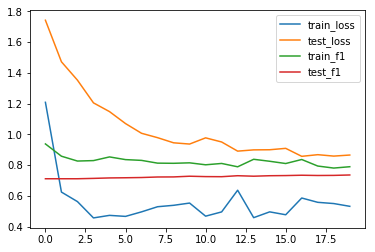

In [15]:
import matplotlib.pyplot as plt
plt.plot(train_loss,label='train_loss')
plt.plot(test_loss,label='test_loss')
plt.plot(train_f1,label='train_f1')
plt.plot(test_f1,label='test_f1')
plt.legend()
plt.show()

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from IPython.core.debugger import set_trace
import os
from pathlib import Path
import glob
from shutil import copyfile
import numpy as np
from PIL import Image
import random
cwd = os.getcwd() #Directory of training images
torch.cuda.is_available()
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True
torch.backends.cudnn.fastest = True

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3*512*512, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 28)
        
    def forward(self, x):
        x = x.view(-1, 3*512*512)
        
        x1 = F.relu(self.fc1(x))
        x2 = F.relu(self.fc2(x1))
        x3 = self.fc3(x2)

        return torch.sigmoid(x3)
    
    def name(self):
        return "MLP"
model = MLP().cuda()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

criterion = nn.BCELoss()
cwd = os.getcwd()

#Read training image names and labels into pandas dataframe
df = pd.read_csv('train.csv')

labels = df['Target'].values

#Convert labels to a format MultiLabelBinarizer() can use
#ex. "3 5 7" -> "3,5,7"
temp = []
for i in labels:
    temp.append( i.replace(" ", ",").split(','))

#Transform labels from strings to multilabel encoding
#ex. If 7 total classes: "3, 5, 7" -> [0 0 1 0 1 0 1]
trans = MultiLabelBinarizer()
multi_labels = trans.fit_transform(temp)


class CustomDatasetFromImages():
    def __init__(self, path, flip, labels):
        
        #flip images, true or false
        self.flip = flip
        self.to_tensor = transforms.ToTensor()
        # Read the csv file
        self.data_info = pd.read_csv('train.csv', header=None)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[1:, 0])
        # Second column is the labels
        self.label_arr = labels
        self.path = path
        
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        
        #Get image name from the pandas df
        single_image_name = self.path + self.image_arr[index]
        
        #Load image channels
        img_as_img1 = Image.open(single_image_name+'_blue.png')
        img_as_img2 = Image.open(single_image_name+'_yellow.png')
        img_as_img3 = Image.open(single_image_name+'_green.png')
        
        #Randomly flip images
        tf = transforms.RandomVerticalFlip(p=1)
        if self.flip and (random.uniform(0, 1) > 0.5):
            img_as_img1 = tf(img_as_img1)
            img_as_img2 = tf(img_as_img2)
            img_as_img3 = tf(img_as_img3)
            
      
        # Transform image to tensor
        img_as_tensor1 = self.to_tensor(img_as_img1)
        img_as_tensor2 = self.to_tensor(img_as_img2)
        img_as_tensor3 = self.to_tensor(img_as_img3)
        image = torch.cat((img_as_tensor1.reshape(1,512,512), img_as_tensor2.reshape(1,512,512)), dim=0)
        image = torch.cat((image, img_as_tensor3.reshape(1,512,512)), dim=0)
        # Get label(class) of the image based on the cropped pandas column
        
        #Normalize tensor. Mean and std chosen based on pytorch transfer learning tutorial
        tf = transforms.Normalize(mean=[0.485],std=[0.229])
        image = tf(image)
        
        single_image_label = self.label_arr[index]

        return (image, single_image_label)

    def __len__(self):
        return self.data_len

#Build data loader
batch_size = 1
img_dir = cwd + '/Train/'
train = CustomDatasetFromImages(img_dir,flip=True,labels=multi_labels)
train_loader = torch.utils.data.DataLoader(train,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=0)

train_loss = []
train_f1 = []
test_loss = []
test_f1 = []
epochs = 20
for epoch in range(epochs):
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    test_cnt = 0
    TP = 0 #true positive
    FP = 0 #false positive
    FN = 0 #false negative
    for batch_idx, (x, target) in enumerate(train_loader):
            #Hardcoded break after all images are loaded, due to bug in for loop.
            if (batch_idx + 1) * batch_size >= 31072:
                break
            #Load target labels and image batch into GPU
            target = target.float().cuda()
            x = x.cuda()
            
            optimizer.zero_grad()
            #Get predictions
            out = model(x)
            #print(out.shape)
            #Get loss from loss function
            loss = criterion(out, target)

            #Calculate accuracy of predictions. Only True Positives and f1 score
            for indx in range(1):
                acc = 0
                for x in range(len(out[indx,:])):
                    if target[indx,x].item() > 0.5:
                        if out[indx,x].item() > 0.5:
                            TP += 1
                        else:
                            FN += 1
                    else:
                        if out[indx,x].item() > 0.5:
                            FP += 1
            
                    total_cnt += 1
                    
            ave_loss = ave_loss * 0.9 + loss.item() * 0.1
            
            if TP == 0 and FP == 0:
                FP = 1
            if TP == 0 and FN == 0:
                FN = 1
            
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            if precision == 0 and recall == 0:
                recall = 1
            f1 = 2*((precision*recall)/(precision+recall))
            
            if (batch_idx + 1) <= 24848:

                loss.backward()
                optimizer.step()
                if (batch_idx + 1) >= 24848:
                    train_loss.append(ave_loss)
                    train_f1.append(f1)
                    print('==>>> epoch: {}, train loss: {:.6f}, acc: {:.3f}, f1:{:.3f}'.format(
                        epoch, ave_loss, TP*1.0/total_cnt, f1))
            
            else:
                if test_cnt == 0:
                    correct_cnt = 0
                    total_cnt += 0
                    TP = 0
                    FP = 0
                    FN = 0
                    test_cnt += 1
                if (batch_idx + 1)  >= (31072 - 1):
                    test_loss.append(ave_loss)
                    test_f1.append(f1)
                    print('==>>> epoch: {}, test loss: {:.6f}, acc: {:.3f}, f1:{:.3f}'.format(
                            epoch, ave_loss, correct_cnt*1.0/total_cnt, f1))
                    


==>>> epoch: 0, train loss: 7.398257, acc: 0.025, f1:0.174
==>>> epoch: 0, test loss: 6.906334, acc: 0.000, f1:0.167
==>>> epoch: 1, train loss: 7.398257, acc: 0.026, f1:0.166
==>>> epoch: 1, test loss: 6.906334, acc: 0.000, f1:0.167
==>>> epoch: 2, train loss: 7.398257, acc: 0.026, f1:0.166
==>>> epoch: 2, test loss: 6.906334, acc: 0.000, f1:0.167


KeyboardInterrupt: 